In [1]:
import cv2
import imagehash
import numpy as np
import os
from os import listdir
from pylab import *
from PIL import Image
from scipy.cluster.vq import *
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn import tree, svm, linear_model
from sklearn.metrics import confusion_matrix
from imageio import imread

In [2]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

In [3]:
!pip install imagehash

In [43]:
genuine_images_path = "/content/genuine"
forged_images_path = "/content/forged"

genuine_image_filenames = listdir(genuine_images_path)
forged_image_filenames = listdir(forged_images_path)

In [44]:
genuine_image_features = [[] for x in range(273)]
forged_image_features = [[] for x in range(273)]

for name in genuine_image_filenames:
    signature_id = name.split('_')[0][-3:]
    if signature_id.isdigit():
        signature_id = int(signature_id)
        genuine_image_features[signature_id - 1].append({"name": name})
#
for name in forged_image_filenames:
    signature_id = name.split('_')[0][-3:]
    if signature_id.isdigit():
        signature_id = int(signature_id)
        forged_image_features[signature_id - 1].append({"name": name})

In [46]:
def preprocess_image(image_path, display=True): #initially in the code False
    """
    1) Convert image to gray scale
    2) Threshold image

    :param image_path: image path
    :param display: flag - if true display images
    :return: preprocessed image
    """
    raw_image = cv2.imread(image_path)
    if len(raw_image.shape)<3:
        bw_image = 255-raw_image
    else:
        bw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2GRAY)
        bw_image = 255 - bw_image

    if display:
        plt.figure(figsize = [8,8])
        plt.imshow(bw_image, cmap='gray')
        plt.axis('off')
        plt.show()

    _, threshold_image = cv2.threshold(bw_image, 30, 255, 0)

    if display:
        plt.figure(figsize = [8,8])
        plt.imshow(threshold_image, cmap='gray')
        plt.axis('off')
        plt.show()

    return threshold_image

In [47]:
def get_contour_features(preprocessed_image, display=False): #initially in the code False
    """
    :param preprocessed_image: preprocessed image
    :param display: flag - if true display images
    :return: aspect ratio of bounding rectangle, area of bounding rectangle, contours and convex hull
    """

    rect = cv2.minAreaRect(cv2.findNonZero(preprocessed_image))
    box = cv2.boxPoints(rect)
    box = np.int0(box)

    w = np.linalg.norm(box[0] - box[1])
    h = np.linalg.norm(box[1] - box[2])

    aspect_ratio = max(w, h) / min(w, h)
    bounding_rect_area = w * h

    if display:
        image1 = cv2.drawContours(preprocessed_image.copy(), [box], 0, (120, 120, 120), 2)
        plt.figure(figsize = [8,8])
        plt.imshow(cv2.resize(image1, (0, 0), fx=2.5, fy=2.5),cmap = 'gray')
        plt.axis('off')
        plt.show()

    hull = cv2.convexHull(cv2.findNonZero(preprocessed_image))

    if display:
        convex_hull_image = cv2.drawContours(preprocessed_image.copy(), [hull], 0, (120, 120, 120), 2)
        plt.figure(figsize = [8,8])
        plt.imshow(cv2.resize(convex_hull_image, (0, 0), fx=2.5, fy=2.5),cmap='gray')
        plt.axis('off')
        plt.show()

    contours, _ = cv2.findContours(preprocessed_image.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


    if display:
        contour_image = cv2.drawContours(preprocessed_image.copy(), contours, -1, (120, 120, 120), 3)
        plt.figure(figsize = [8,8])
        plt.imshow(cv2.resize(contour_image, (0, 0), fx=2.5, fy=2.5), cmap = 'gray')
        plt.axis('off')
        plt.show()


    contour_area = 0
    for cnt in contours:
        contour_area += cv2.contourArea(cnt)
    hull_area = cv2.contourArea(hull)

    return aspect_ratio, bounding_rect_area, hull_area, contour_area

In [48]:
def sift(preprocessed_image, image_path, display=True):
    raw_image = cv2.imread(image_path)
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(preprocessed_image, None)

    if display:
        cv2.drawKeypoints(preprocessed_image, kp, raw_image)
        plt.figure(figsize = [8,8])
        plt.imshow(cv2.resize(raw_image, (0, 0), fx=3, fy=3))
        plt.axis('off')
        plt.show()

    return (image_path, des)

In [73]:
def run(clsf):
    des_list = []
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    im_contour_features = []
    display = False

    for i in range(273):
        print('Learning '+str(i+1)+'th image')
        des_list = []
        for im in genuine_image_features[i]:
            image_path = genuine_images_path + "/" + im['name']
            preprocessed_image = preprocess_image(image_path)
            hash = imagehash.phash(Image.open(image_path))

            aspect_ratio, bounding_rect_area, convex_hull_area, contours_area = get_contour_features(preprocessed_image.copy(), display=display)

            hash = int(str(hash), 16)
            im['hash'] = hash
            im['aspect_ratio'] = aspect_ratio
            im['hull_area/bounding_area'] = convex_hull_area / bounding_rect_area
            im['contour_area/bounding_area'] = contours_area / bounding_rect_area

            im_contour_features.append([hash, aspect_ratio, convex_hull_area / bounding_rect_area, contours_area / bounding_rect_area])

            des_list.append(sift(preprocessed_image, image_path))

        if len(des_list)==0:
#             print(image_path+' does not have suffiecient features, skipping')
            pass

        for im in forged_image_features[i]:
            image_path = forged_images_path + "/" + im['name']
            preprocessed_image = preprocess_image(image_path)
            hash = imagehash.phash(Image.open(image_path))

            aspect_ratio, bounding_rect_area, convex_hull_area, contours_area = get_contour_features(preprocessed_image.copy(), display=display)

            hash = int(str(hash), 16)
            im['hash'] = hash
            im['aspect_ratio'] = aspect_ratio
            im['hull_area/bounding_area'] = convex_hull_area / bounding_rect_area
            im['contour_area/bounding_area'] = contours_area / bounding_rect_area

            im_contour_features.append([hash, aspect_ratio, convex_hull_area / bounding_rect_area, contours_area / bounding_rect_area])

            des_list.append(sift(preprocessed_image, image_path))

        if len(des_list)==0:
#             print(image_path+' does not have suffiecient features, skipping')
            continue
        # descriptors = des_list[0][1]
        # Initialize descriptors with descriptors from the first image
        descriptors = des_list[0][1]

        # Concatenate descriptors from other images
        for image_path, descriptor in des_list[1:]:
            descriptors = np.vstack((descriptors, descriptor))
        k = 170
        voc, variance = kmeans(descriptors, k, 1)

        # Calculate the histogram of features
        im_features = np.zeros((len(genuine_image_features[i]) + len(forged_image_features[i]), k + 4), "float32")
        for i in range(len(genuine_image_features[i]) + len(forged_image_features[i])):
            words, distance = vq(des_list[i][1], voc)
            for w in words:
                im_features[i][w] += 1

            for j in range(4):
                im_features[i][k + j] = im_contour_features[i][j]

        # nbr_occurences = np.sum((im_features > 0) * 1, axis=0)
        # idf = np.array(np.log((1.0 * len(image_paths) + 1) / (1.0 * nbr_occurences + 1)), 'float32')

        # Scaling the words
        stdSlr = StandardScaler().fit(im_features)
        im_features = stdSlr.transform(im_features)

        from sklearn.model_selection import train_test_split

# Split genuine and forged features into training and testing sets
        train_genuine_features, test_genuine_features = train_test_split(im_features[:3], test_size=0.2, random_state=42)
        train_forged_features, test_forged_features = train_test_split(im_features[3:5], test_size=0.2, random_state=42)

        clf = clsf
#     clf = linear_model.LogisticRegression(C=1e5)

#     clf = tree.DecisionTreeClassifier()
#     clf = tree.DecisionTreeRegressor()
#     clf = svm.SVC()

        clf.fit(np.concatenate((train_forged_features, train_genuine_features)),np.array([1 for x in range(len(train_forged_features))] + [2 for x in range(len(train_genuine_features))]))

        genuine_res = clf.predict(test_genuine_features)

        for res in genuine_res:
            if int(res) == 2:
                true_positive += 1
            else:
                false_negative += 1

        forged_res = clf.predict(test_forged_features)

        for res in forged_res:
            if int(res) == 1:
                true_negative += 1
            else:
                false_positive += 1

#         print('-----------------------------------------------')
    print('Completed Learning')
    print(' ')
    accuracy = float(true_positive + true_negative) / (true_positive + true_negative + false_negative + false_positive)
    if (true_positive+false_positive == 0):
      true_positive = 1
    precision = float(float(true_positive) / float(true_positive + false_positive))
    recall = float(float(true_positive) / float(true_positive + false_negative))
    far = float(false_positive) / (false_positive + true_negative)
    frr = float(false_negative) / (false_negative + true_positive)
    f1_score = float(2 * precision * recall) / (precision + recall)
    print('Stats')
    print(' ')
    print("True Positives: ", true_positive)
    print("True Negatives: ", true_negative)
    print("False Positives: ", false_positive)
    print("False Negatives: ", false_negative)
    print("Accuracy: ", round(accuracy, 2))
    print("Precision: ", round(precision, 2))
    print("Recall: ", round(recall, 2))
    print("FAR: ",round(far, 2))
    print("FRR: ",round(frr, 2))
    print("F1 score: ", round(f1_score, 2))

**LINEAR SVC()**

Learning 1th image


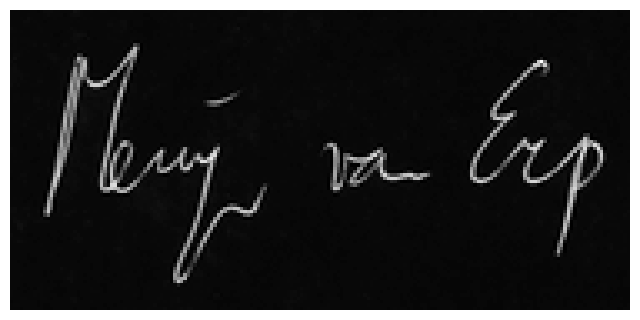

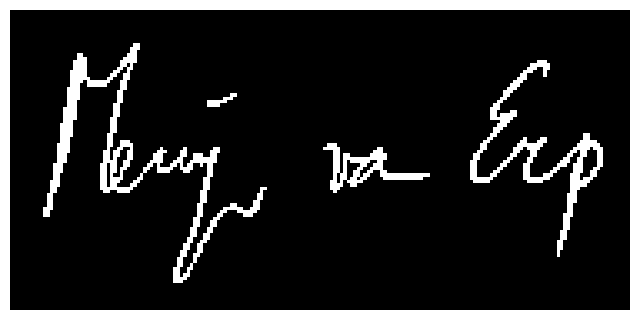

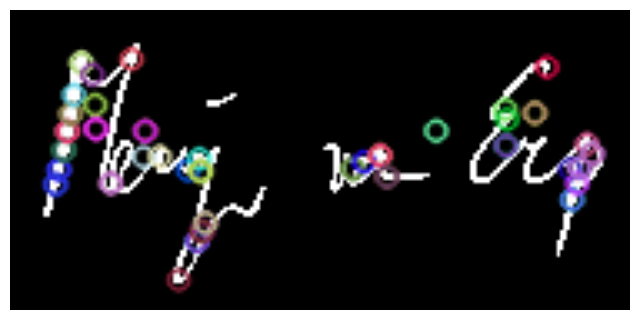

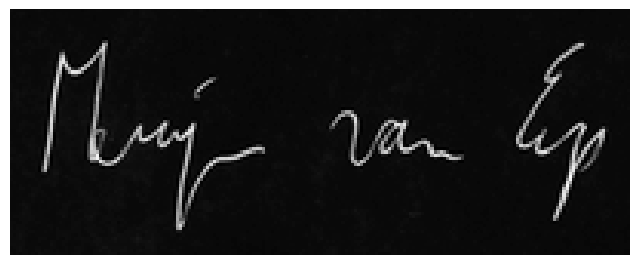

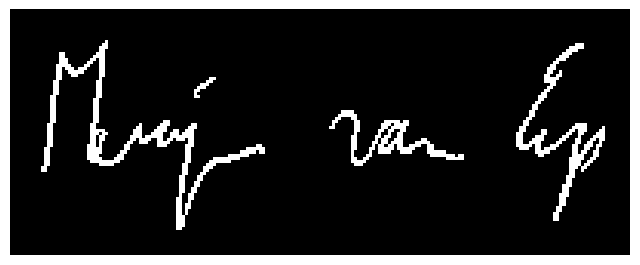

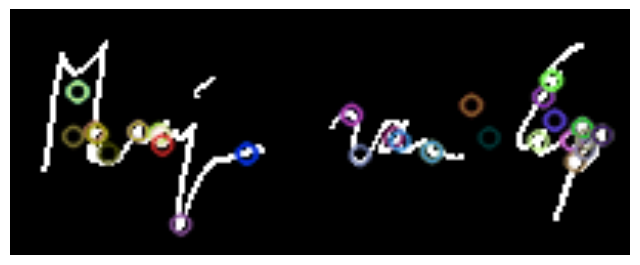

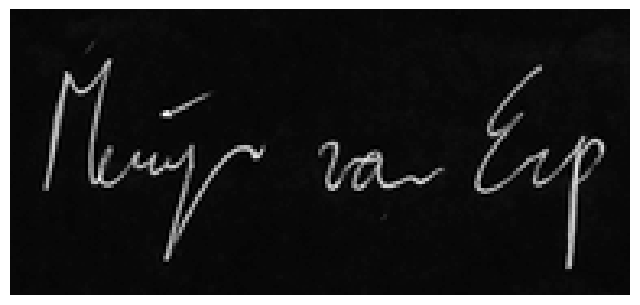

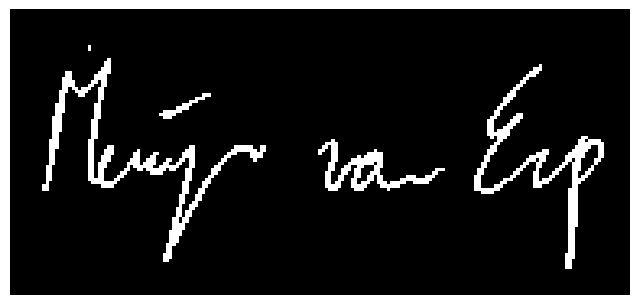

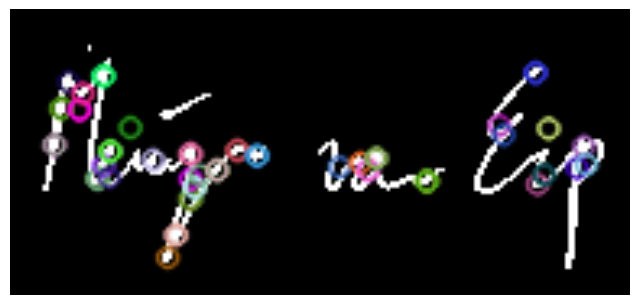

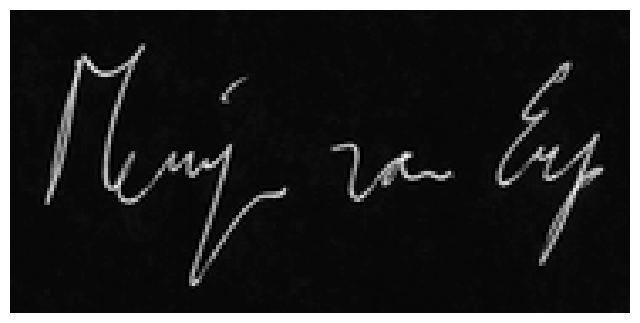

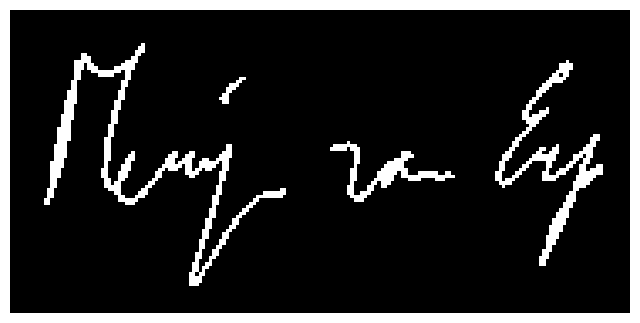

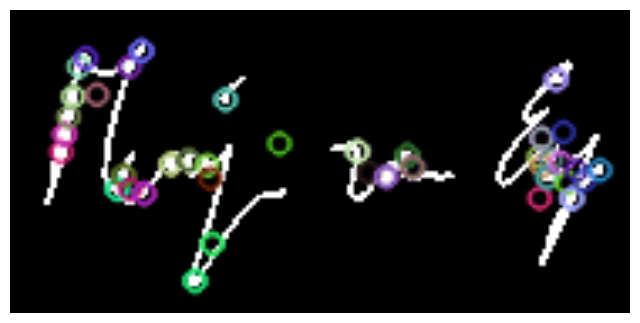

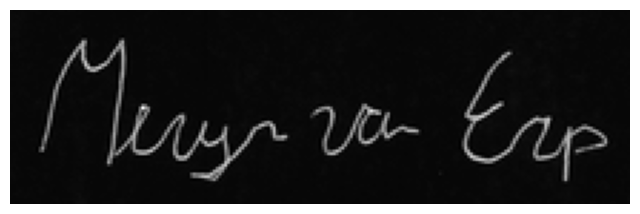

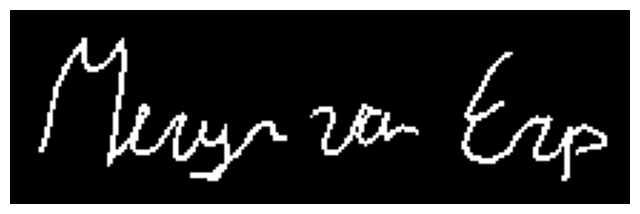

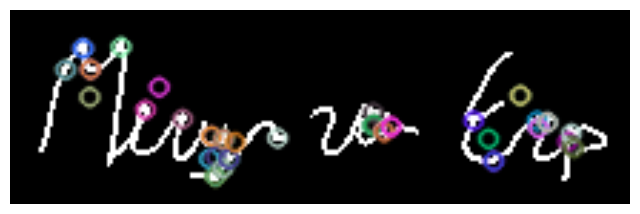

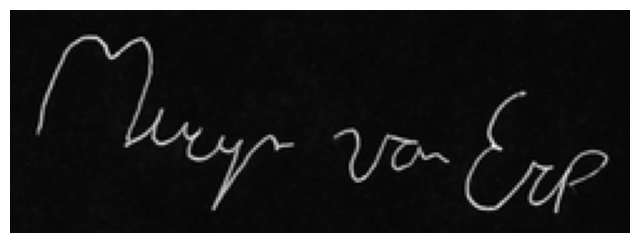

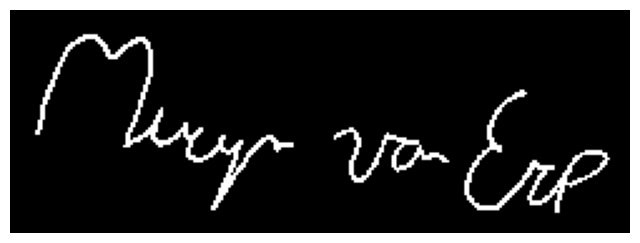

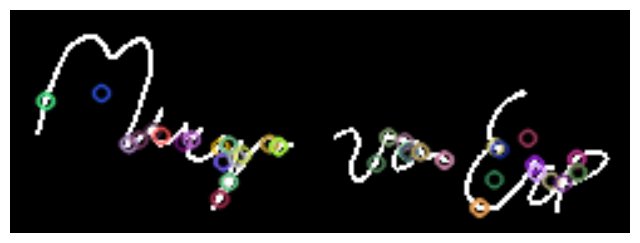

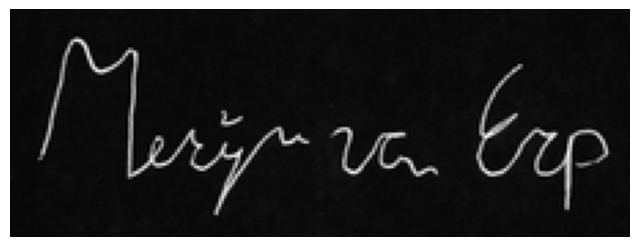

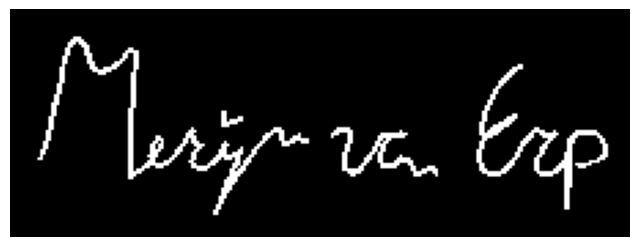

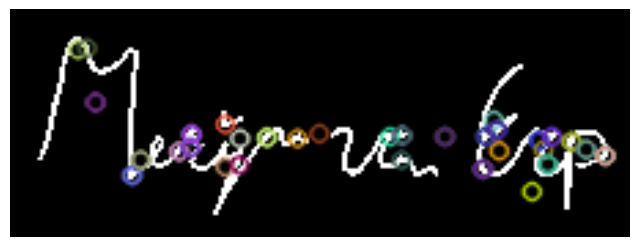

Learning 2th image
Learning 3th image
Learning 4th image
Learning 5th image
Learning 6th image
Learning 7th image
Learning 8th image
Learning 9th image
Learning 10th image
Learning 11th image
Learning 12th image
Learning 13th image
Learning 14th image
Learning 15th image
Learning 16th image
Learning 17th image
Learning 18th image
Learning 19th image
Learning 20th image
Learning 21th image
Learning 22th image
Learning 23th image
Learning 24th image
Learning 25th image
Learning 26th image
Learning 27th image
Learning 28th image
Learning 29th image
Learning 30th image
Learning 31th image
Learning 32th image
Learning 33th image
Learning 34th image
Learning 35th image
Learning 36th image
Learning 37th image
Learning 38th image
Learning 39th image
Learning 40th image
Learning 41th image
Learning 42th image
Learning 43th image
Learning 44th image
Learning 45th image
Learning 46th image
Learning 47th image
Learning 48th image
Learning 49th image
Learning 50th image
Learning 51th image
Learning

In [74]:
clsf = LinearSVC()
run(clsf)

**LOGISTIC REGRESSION**

Learning 1th image


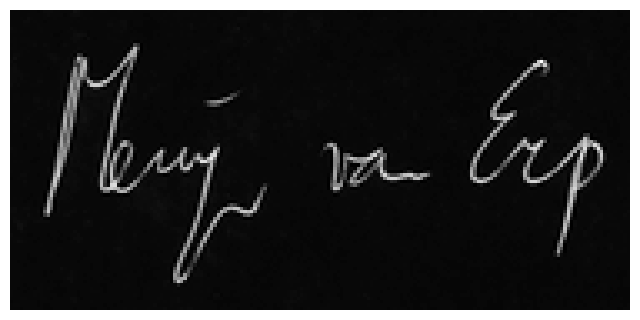

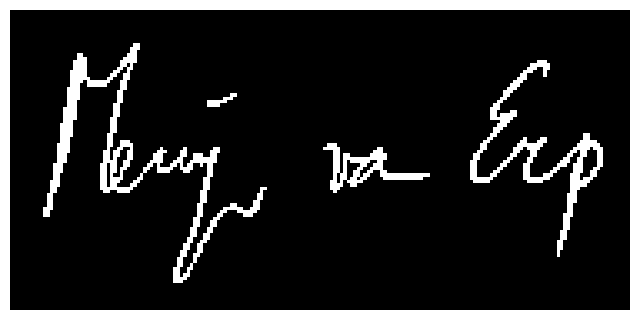

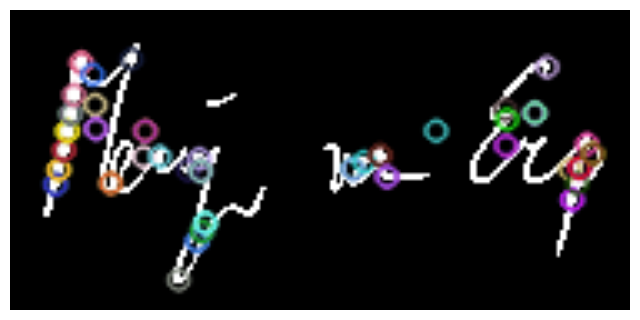

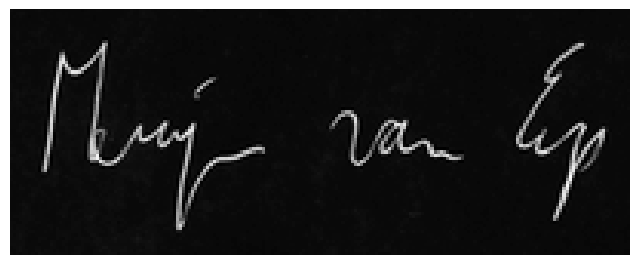

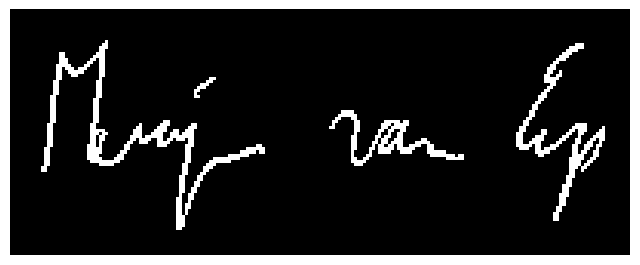

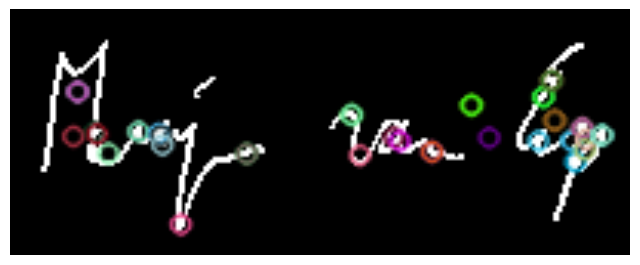

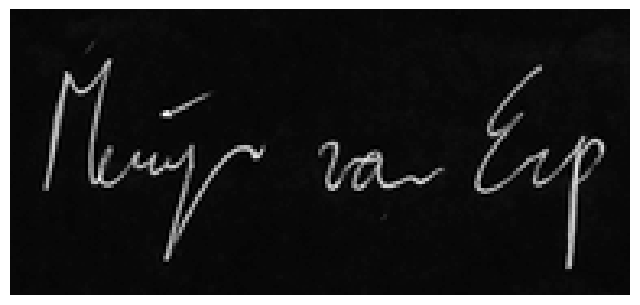

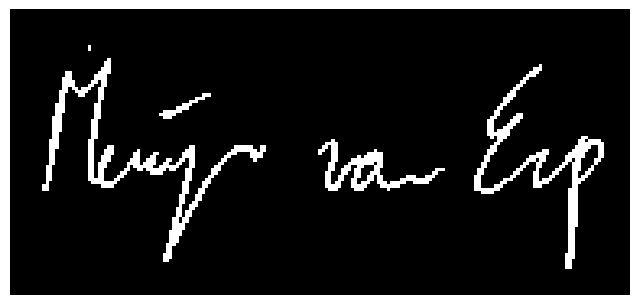

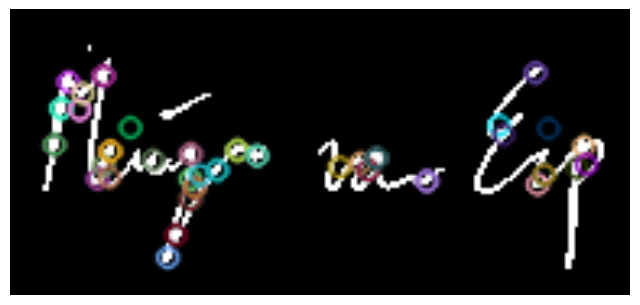

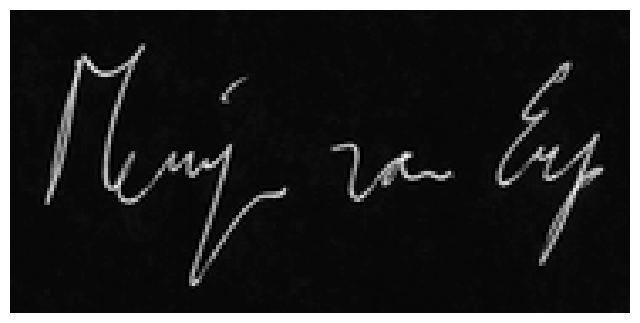

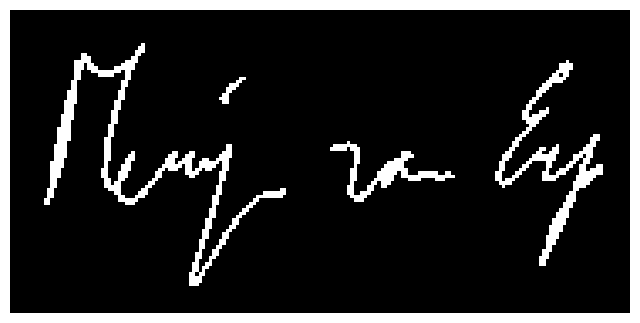

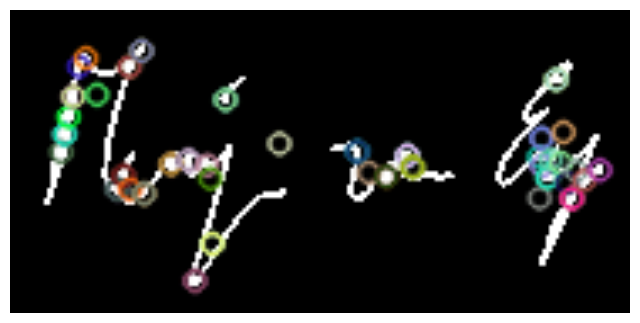

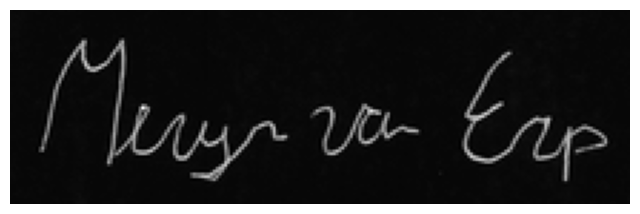

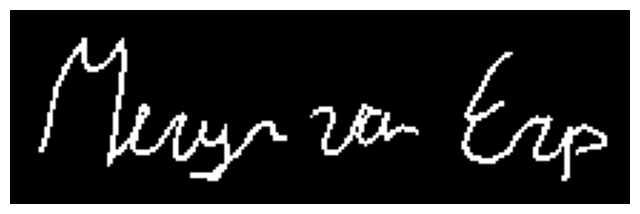

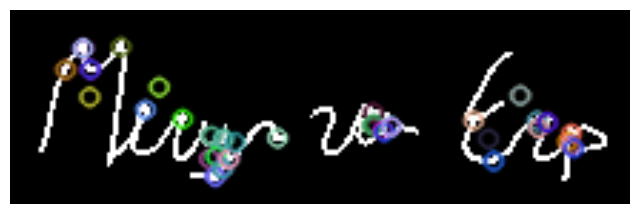

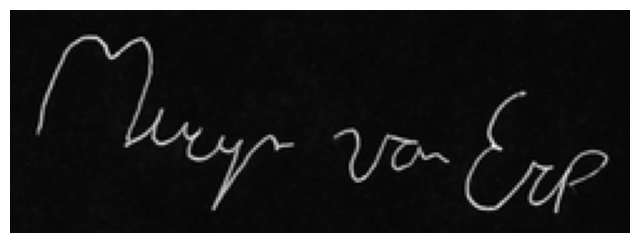

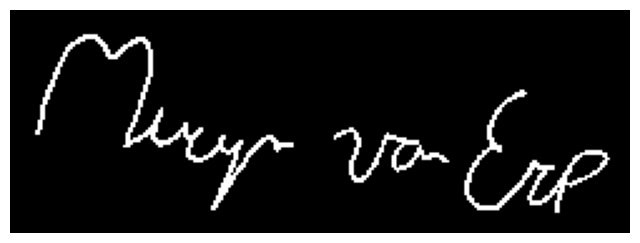

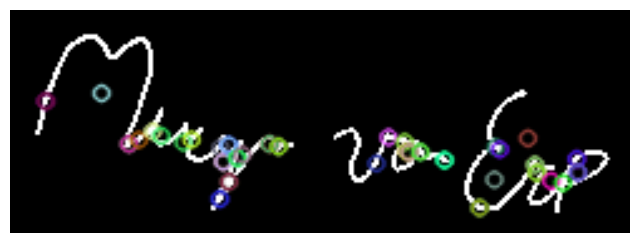

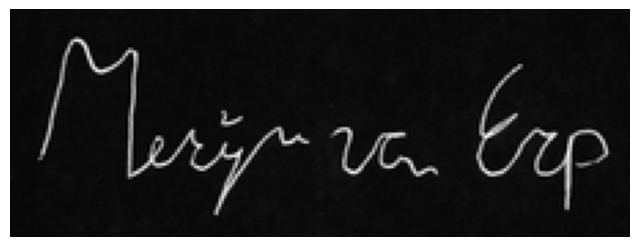

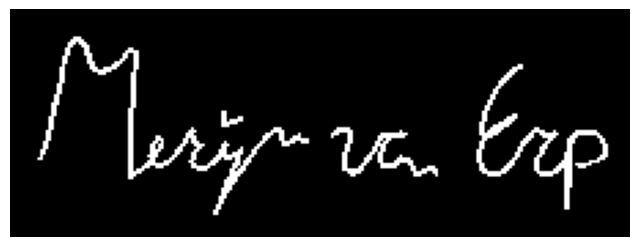

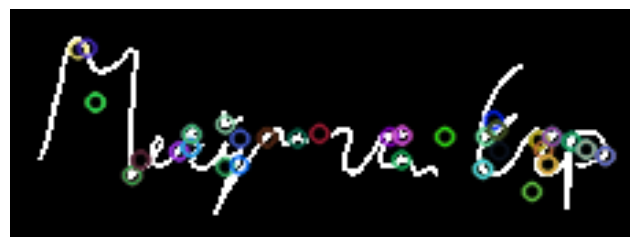

Learning 2th image
Learning 3th image
Learning 4th image
Learning 5th image
Learning 6th image
Learning 7th image
Learning 8th image
Learning 9th image
Learning 10th image
Learning 11th image
Learning 12th image
Learning 13th image
Learning 14th image
Learning 15th image
Learning 16th image
Learning 17th image
Learning 18th image
Learning 19th image
Learning 20th image
Learning 21th image
Learning 22th image
Learning 23th image
Learning 24th image
Learning 25th image
Learning 26th image
Learning 27th image
Learning 28th image
Learning 29th image
Learning 30th image
Learning 31th image
Learning 32th image
Learning 33th image
Learning 34th image
Learning 35th image
Learning 36th image
Learning 37th image
Learning 38th image
Learning 39th image
Learning 40th image
Learning 41th image
Learning 42th image
Learning 43th image
Learning 44th image
Learning 45th image
Learning 46th image
Learning 47th image
Learning 48th image
Learning 49th image
Learning 50th image
Learning 51th image
Learning

In [75]:
clsf = linear_model.LogisticRegression(C=1e5)
run(clsf)

**DECISION TREE CLASSIFIER**

Learning 1th image


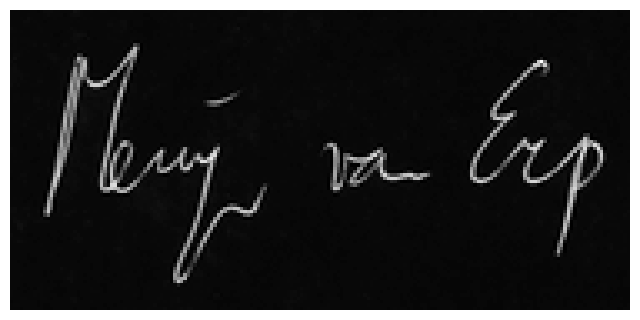

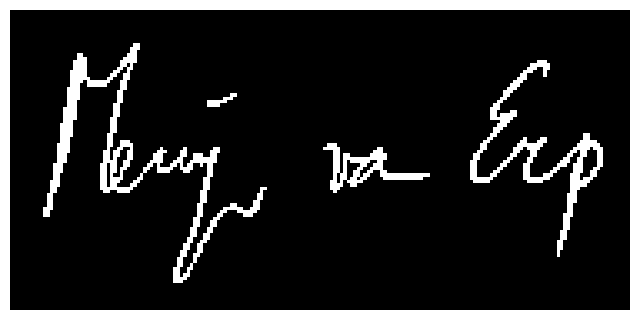

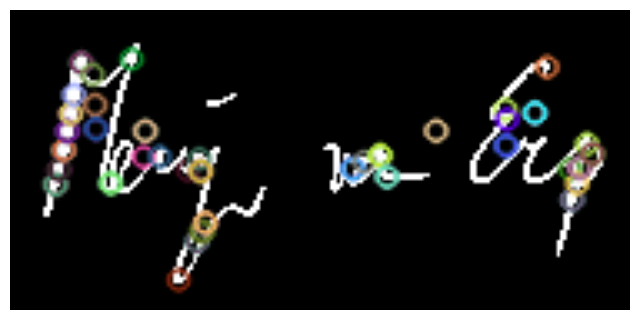

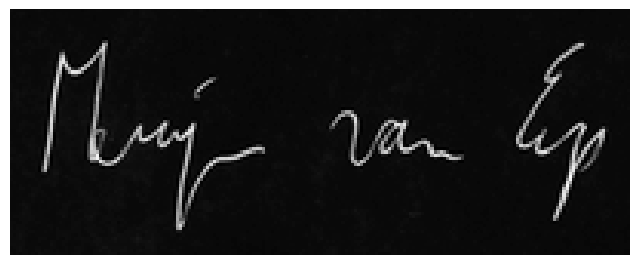

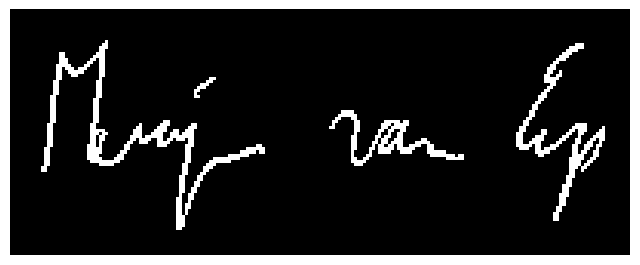

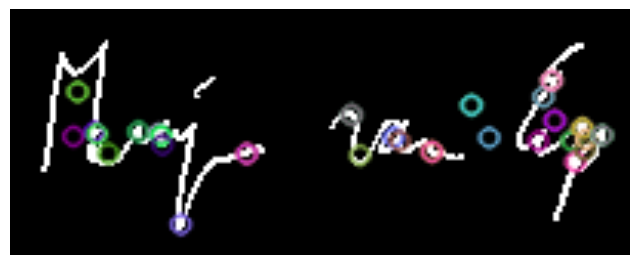

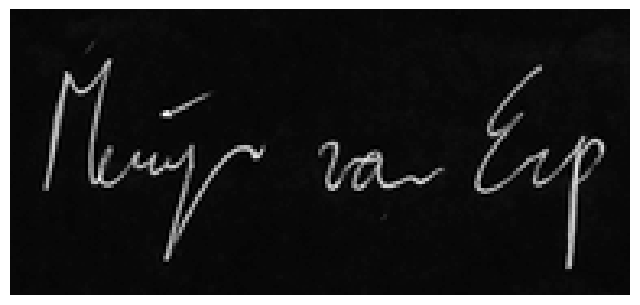

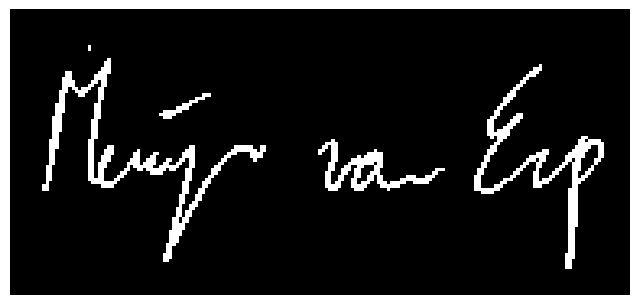

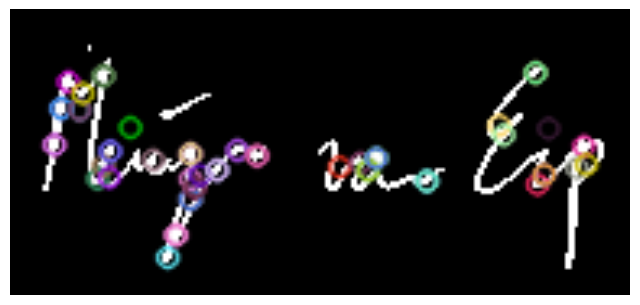

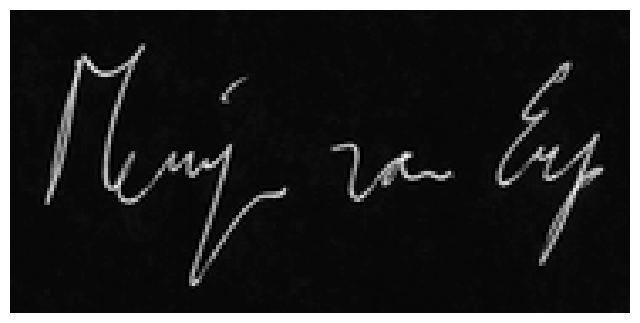

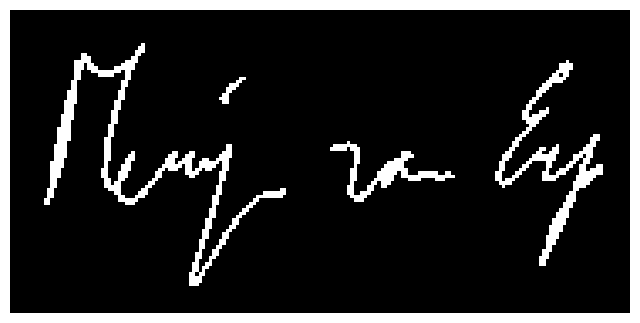

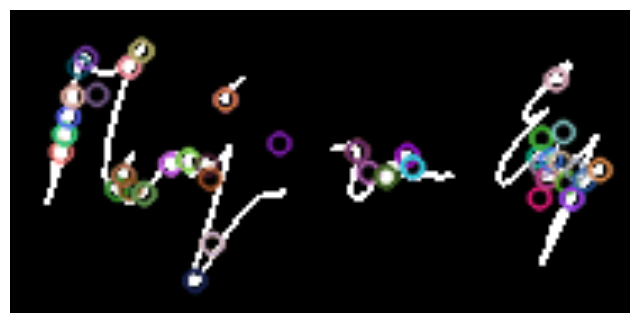

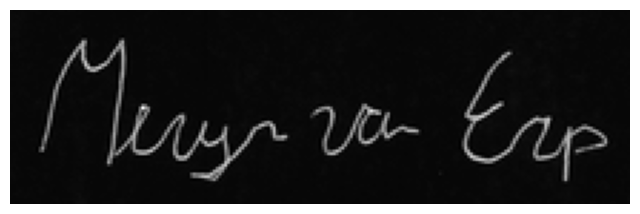

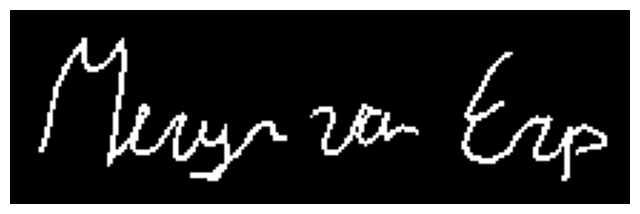

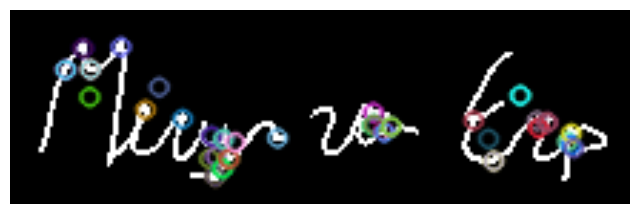

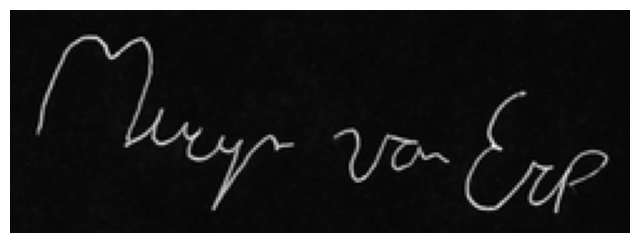

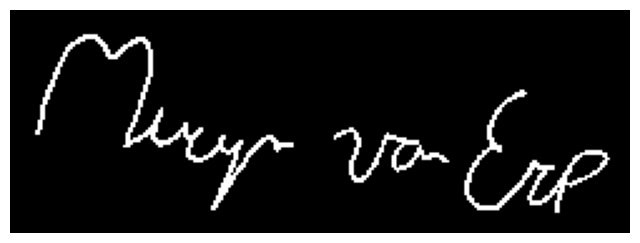

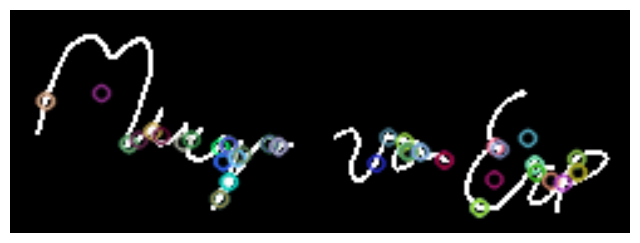

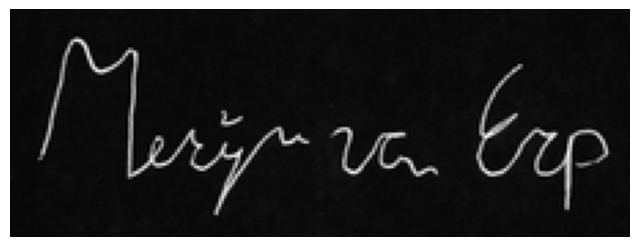

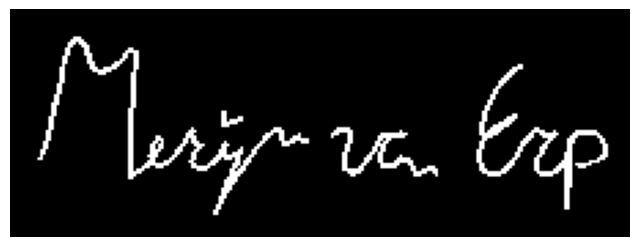

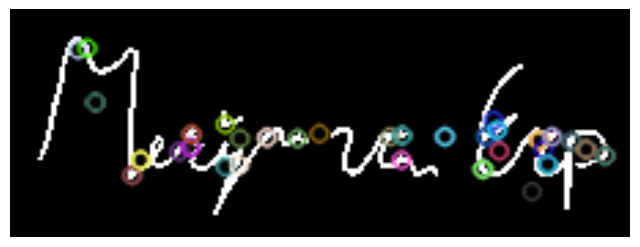

Learning 2th image
Learning 3th image
Learning 4th image
Learning 5th image
Learning 6th image
Learning 7th image
Learning 8th image
Learning 9th image
Learning 10th image
Learning 11th image
Learning 12th image
Learning 13th image
Learning 14th image
Learning 15th image
Learning 16th image
Learning 17th image
Learning 18th image
Learning 19th image
Learning 20th image
Learning 21th image
Learning 22th image
Learning 23th image
Learning 24th image
Learning 25th image
Learning 26th image
Learning 27th image
Learning 28th image
Learning 29th image
Learning 30th image
Learning 31th image
Learning 32th image
Learning 33th image
Learning 34th image
Learning 35th image
Learning 36th image
Learning 37th image
Learning 38th image
Learning 39th image
Learning 40th image
Learning 41th image
Learning 42th image
Learning 43th image
Learning 44th image
Learning 45th image
Learning 46th image
Learning 47th image
Learning 48th image
Learning 49th image
Learning 50th image
Learning 51th image
Learning

In [55]:
clsf = tree.DecisionTreeClassifier()
run(clsf)

**SVM**

Learning 1th image


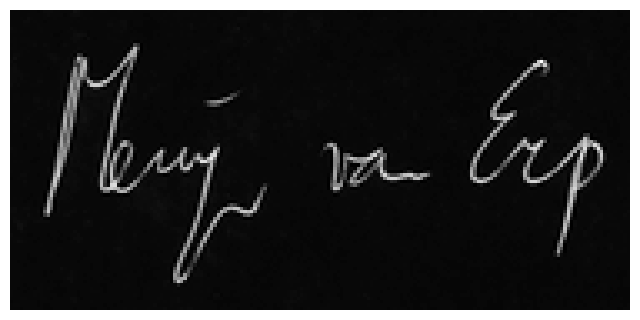

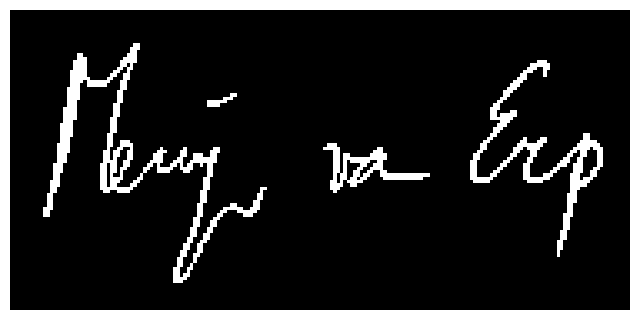

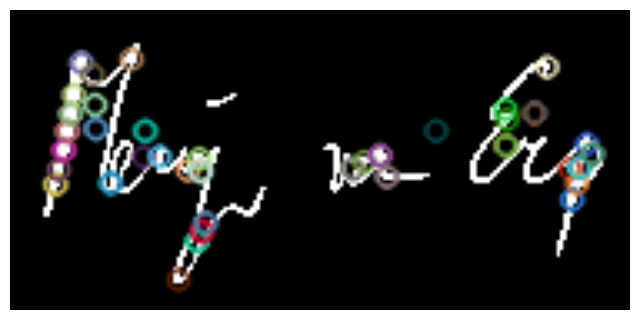

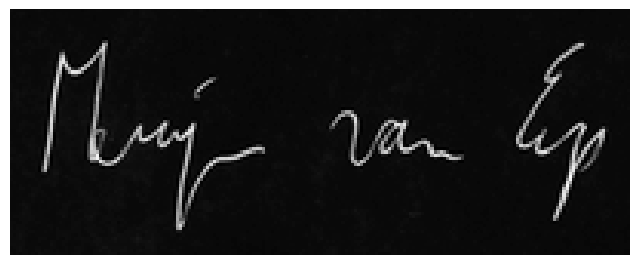

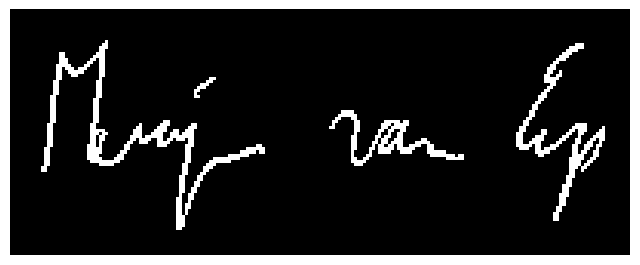

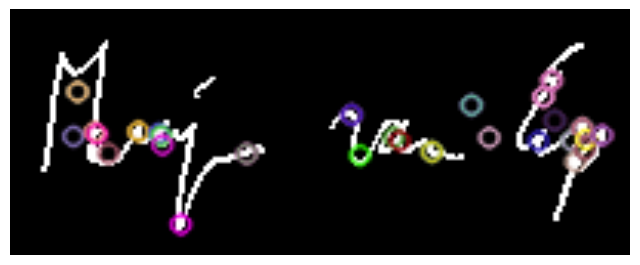

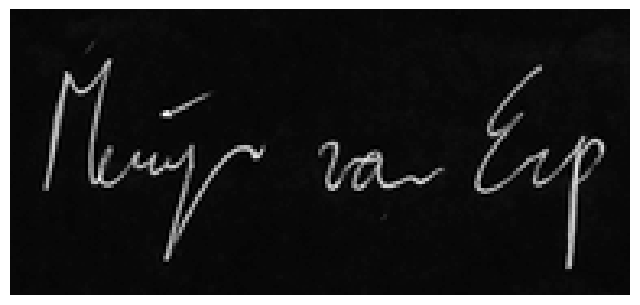

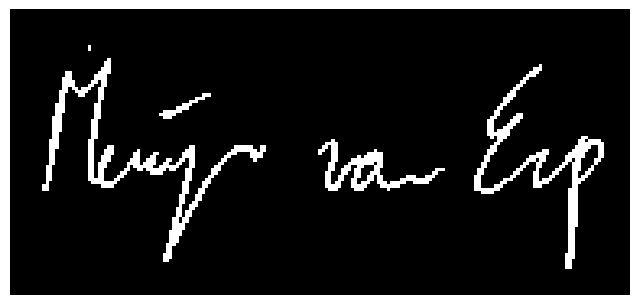

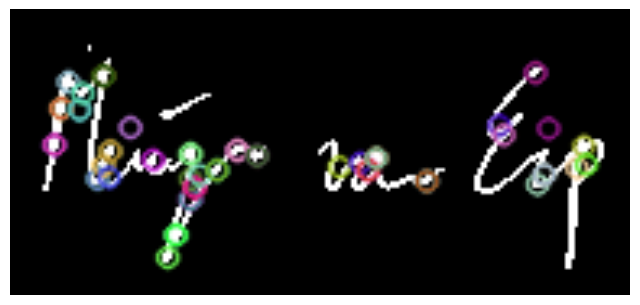

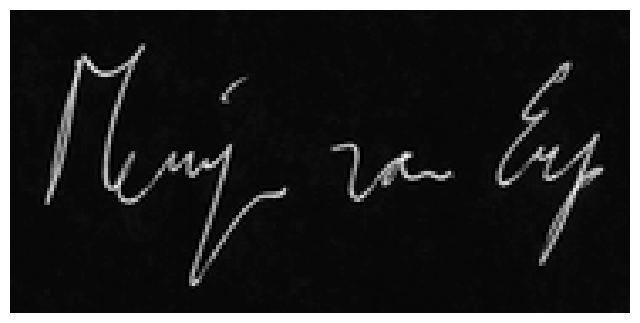

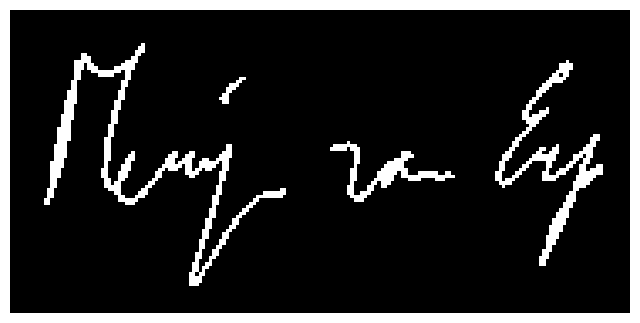

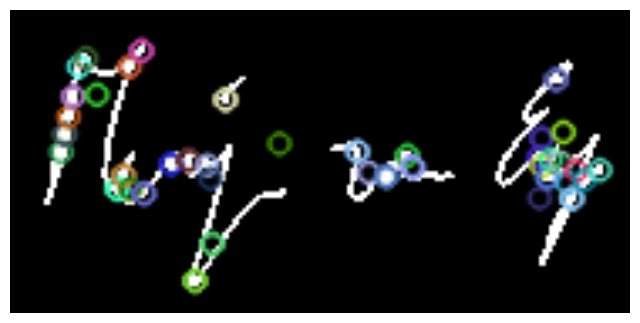

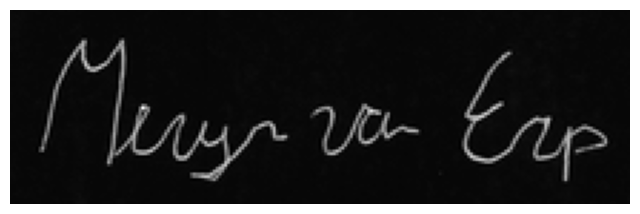

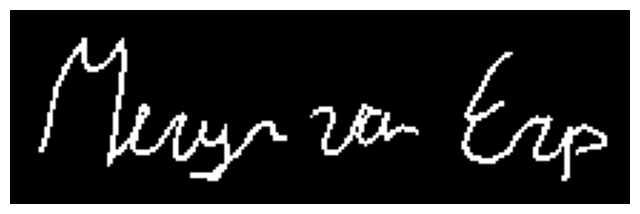

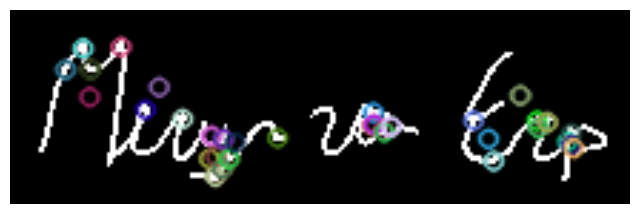

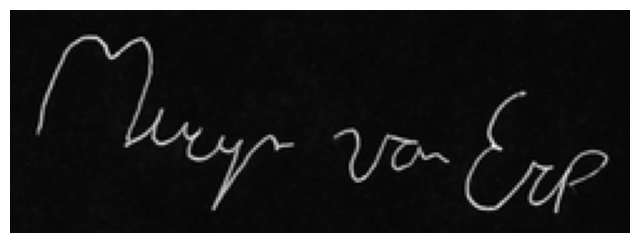

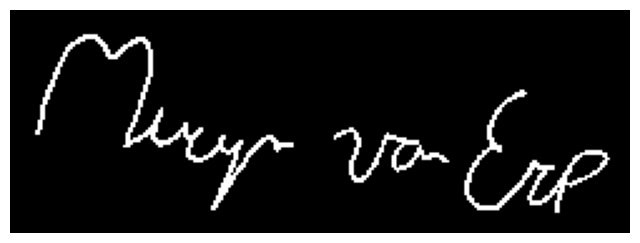

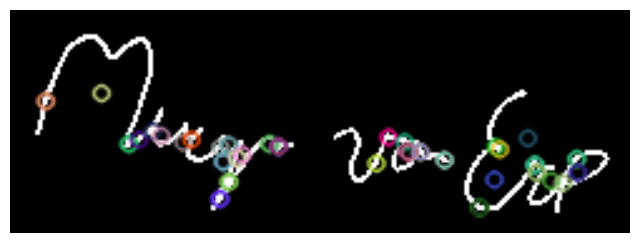

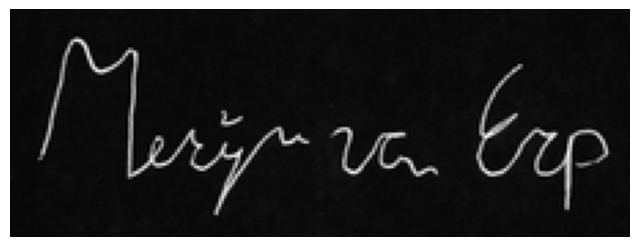

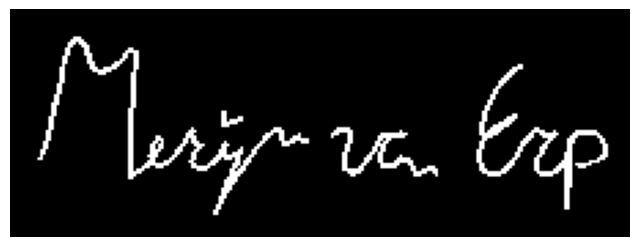

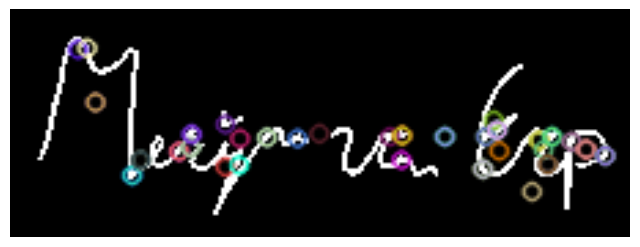

Learning 2th image
Learning 3th image
Learning 4th image
Learning 5th image
Learning 6th image
Learning 7th image
Learning 8th image
Learning 9th image
Learning 10th image
Learning 11th image
Learning 12th image
Learning 13th image
Learning 14th image
Learning 15th image
Learning 16th image
Learning 17th image
Learning 18th image
Learning 19th image
Learning 20th image
Learning 21th image
Learning 22th image
Learning 23th image
Learning 24th image
Learning 25th image
Learning 26th image
Learning 27th image
Learning 28th image
Learning 29th image
Learning 30th image
Learning 31th image
Learning 32th image
Learning 33th image
Learning 34th image
Learning 35th image
Learning 36th image
Learning 37th image
Learning 38th image
Learning 39th image
Learning 40th image
Learning 41th image
Learning 42th image
Learning 43th image
Learning 44th image
Learning 45th image
Learning 46th image
Learning 47th image
Learning 48th image
Learning 49th image
Learning 50th image
Learning 51th image
Learning

In [76]:
clf = svm.SVC()
run(clsf)